In [48]:
# Initial Setup:
# Import all the libraries we need

import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random
import pandas as pd

from BSE import market_session

# The next are helper functions that you will use later, if they don't make 
# much sense now, don't worry too much about it they will become clearer later:

# Use this to plot trades of a single experiment
def plot_trades(trial_id):
    prices_fname = '_Assignment/' + trial_id + '_transactions.csv'
    x = np.empty(0)
    y = np.empty(0)
    with open('_testData/' + trial_id + '_transactions.csv', newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

    plt.plot(x, y, 'x', color='black') 
    
# Use this to run an experiment n times and plot all trades
def n_runs_plot(n, trial_id, start_time, end_time, traders_spec, order_sched):
    x = np.empty(0)
    y = np.empty(0)

    for i in range(n):
        trialId = trial_id + '_' + str(i)
        tdump = open('_Assignment/' + trialId + '_avg_balance.csv','w')

        market_session(trialId, start_time, end_time, traders_spec, order_sched, tdump, True, False)
        
        tdump.close()

        with open('_Assignment/' + trialId + '_transactions.csv', newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x,time)
                y = np.append(y,price)

    plt.plot(x, y, 'x', color='black');

# !!! Don't use on it's own   
def getorderprice(i, sched, n, mode):
    pmin = min(sched[0][0], sched[0][1])
    pmax = max(sched[0][0], sched[0][1])
    prange = pmax - pmin
    stepsize = prange / (n - 1)
    halfstep = round(stepsize / 2.0)

    if mode == 'fixed':
        orderprice = pmin + int(i * stepsize)
    elif mode == 'jittered':
        orderprice = pmin + int(i * stepsize) + random.randint(-halfstep, halfstep)
    elif mode == 'random':
        if len(sched) > 1:
            # more than one schedule: choose one equiprobably
            s = random.randint(0, len(sched) - 1)
            pmin = min(sched[s][0], sched[s][1])
            pmax = max(sched[s][0], sched[s][1])
        orderprice = random.randint(pmin, pmax)
    return orderprice    

# !!! Don't use on it's own
def make_supply_demand_plot(bids, asks):
    # total volume up to current order
    volS = 0
    volB = 0

    fig, ax = plt.subplots()
    plt.ylabel('Price')
    plt.xlabel('Quantity')
    
    pr = 0
    for b in bids:
        if pr != 0:
            # vertical line
            ax.plot([volB,volB], [pr,b], 'r-')
        # horizontal lines
        line, = ax.plot([volB,volB+1], [b,b], 'r-')
        volB += 1
        pr = b
    if bids:
        line.set_label('Demand')
        
    pr = 0
    for s in asks:
        if pr != 0:
            # vertical line
            ax.plot([volS,volS], [pr,s], 'b-')
        # horizontal lines
        line, = ax.plot([volS,volS+1], [s,s], 'b-')
        volS += 1
        pr = s
    if asks:
        line.set_label('Supply')
        
    if bids or asks:
        plt.legend()
    plt.show()

# Use this to plot supply and demand curves from supply and demand ranges and stepmode
def sup_dem(seller_num, sup_ranges, buyer_num, dem_ranges, stepmode):
    asks = []
    for s in range(seller_num):
        asks.append(getorderprice(s, sup_ranges, seller_num, stepmode))
    asks.sort()
    bids = []
    for b in range(buyer_num):
        bids.append(getorderprice(b, dem_ranges, buyer_num, stepmode))
    bids.sort()
    bids.reverse()
    
    make_supply_demand_plot(bids, asks) 

# plot sorted trades, useful is some situations - won't be used in this worksheet
def in_order_plot(trial_id):
    prices_fname = '_Assignment/' + trial_id + '_transactions.csv'
    y = np.empty(0)
    with open('_Assignment/' + trial_id + '_transactions.csv', newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            price = float(row[2])
            y = np.append(y,price)
    y = np.sort(y)
    x = list(range(len(y)))

    plt.plot(x, y, 'x', color='black') 

In [49]:
# schedule_offsetfn returns time-dependent offset, to be added to schedule prices
def schedule_offsetfn(t):
    pi2 = math.pi * 2
    c = math.pi * 3000
    wavelength = t / c
    gradient = 100 * t / (c / pi2)
    amplitude = 100 * t / (c / pi2)
    offset = gradient + amplitude * math.sin(wavelength * t)
    return int(round(offset, 0))

def offset_1(t):
    return 1

def offset_2(t):
    return 2

# Solution:
def offset_t(t):
    return int(round(t,0))

range_offset1 = (50, 100, schedule_offsetfn)
range_offset2 = (150, 200, offset_t)

range_offset_both = (50, 100, offset_1, offset_2)

In [50]:
traders = ['ZIP', 'ZIC', 'SHVR', 'GVWY', 'SNPR', 'PRZI', 'PRSH']
for t in traders:
    sellers_spec = [(t, 20)]
    buyers_spec = sellers_spec
    traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

    range1 = (50, 100)
    range2 = (150, 200)

    start_time = 0
    change1_time = 60 * 3
    change2_time = 60 * 7
    end_time = 60 * 10
    supply_schedule = [{'from': start_time, 'to': change1_time, 'ranges': [range1], 'stepmode': 'fixed'},
                       {'from': change1_time, 'to': change2_time, 'ranges': [range2], 'stepmode': 'fixed'},
                       {'from': change2_time, 'to': end_time, 'ranges': [range1], 'stepmode': 'fixed'}]
    demand_schedule = supply_schedule

    order_interval = 15
    order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
                   'interval': order_interval, 'timemode': 'periodic'}

    trial_id = 'test'
    tdump = open('_Assignment/avg_balance_' + t + '.csv','w')
    dump_all = True
    verbose = False

    market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

    tdump.close()
    
    

    


In [51]:
header = ['NoBid', 'NoOffer', 'Avg Change', 'Max Change', 'Avg Profit' , 'Max Profit', 'TraderType']
#Dataset creation function
import pandas as pd
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

traders = ['ZIP', 'ZIC', 'GVWY', 'SNPR', 'PRZI', 'PRSH']
for t in traders:
    df = pd.read_csv('_Assignment/avg_balance_' + t + '_offset.csv')
    testData= df.iloc[:, [2,3,5]] 
    testData.columns = ['bid' , 'best' , 'profit' ]
    testData['bid'] = pd.to_numeric(testData['bid'],errors ='coerce')
    testData['best'] = pd.to_numeric(testData['best'],errors ='coerce')
    NoBid=testData['bid'].isna().sum()
    NoOffer=testData['best'].isna().sum()
    testData['Change'] = testData['best']-testData['bid']
    testData['Change2'] = testData['profit'].diff()
    StandardDev = testData.std()
    MaxChange = testData['Change'].max()
    MaxProfit = testData['Change2'].max()
    AvgChange=StandardDev[3]
    AvgProfit=StandardDev[4]
    TraderType = t
    to_append = f'{NoBid} {NoOffer} {AvgChange} {MaxChange} {AvgProfit} {MaxProfit} {TraderType}'
    file = open('data.csv', 'a', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(to_append.split())

/tmp/ipykernel_11037/3772287931.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testData['bid'] = pd.to_numeric(testData['bid'],errors ='coerce')
/tmp/ipykernel_11037/3772287931.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testData['best'] = pd.to_numeric(testData['best'],errors ='coerce')
/tmp/ipykernel_11037/3772287931.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [ ]:
traders = ['ZIP', 'ZIC', 'SHVR', 'GVWY', 'SNPR', 'PRZI', 'PRSH']
for t in traders:
    sellers_spec = [(t, 20)]
    buyers_spec = sellers_spec
    traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

    range1 = (50, 100, schedule_offsetfn)
    range2 = (150, 200, offset_t)
    start_time = 0
    change1_time = 60 * 3
    change2_time = 60 * 7
    end_time = 60 * 10
    supply_schedule = [{'from': start_time, 'to': change1_time, 'ranges': [range1], 'stepmode': 'fixed'},
                       {'from': change1_time, 'to': change2_time, 'ranges': [range2], 'stepmode': 'fixed'},
                       {'from': change2_time, 'to': end_time, 'ranges': [range1], 'stepmode': 'fixed'}]
    demand_schedule = supply_schedule

    order_interval = 15
    order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
                   'interval': order_interval, 'timemode': 'periodic'}

    trial_id = 'test'
    tdump = open('_Assignment/avg_balance_' + t + '_offset.csv','w')
    dump_all = True
    verbose = False

    market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

    tdump.close()
    
    

    


In [ ]:
header = ['NoBid', 'NoOffer', 'Avg Change', 'Max Change', 'Avg Profit' , 'Max Profit', 'TraderType']
#Dataset creation function
import pandas as pd
file = open('dataoffset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

traders = ['ZIP', 'ZIC', 'GVWY', 'SNPR', 'PRZI', 'PRSH']
for t in traders:
    df = pd.read_csv('_Assignment/avg_balance_' + t + '_offset.csv')
    testData= df.iloc[:, [2,3,5]] 
    testData.columns = ['bid' , 'best' , 'profit' ]
    testData['bid'] = pd.to_numeric(testData['bid'],errors ='coerce')
    testData['best'] = pd.to_numeric(testData['best'],errors ='coerce')
    NoBid=testData['bid'].isna().sum()
    NoOffer=testData['best'].isna().sum()
    testData['Change'] = testData['best']-testData['bid']
    testData['Change2'] = testData['profit'].diff()
    StandardDev = testData.std()
    MaxChange = testData['Change'].max()
    MaxProfit = testData['Change2'].max()
    AvgChange=StandardDev[3]
    AvgProfit=StandardDev[4]
    TraderType = t
    to_append = f'{NoBid} {NoOffer} {AvgChange} {MaxChange} {AvgProfit} {MaxProfit} {TraderType}'
    file = open('dataoffset.csv', 'a', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(to_append.split())

/tmp/ipykernel_11037/2240881326.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testData['bid'] = pd.to_numeric(testData['bid'],errors ='coerce')
/tmp/ipykernel_11037/2240881326.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testData['best'] = pd.to_numeric(testData['best'],errors ='coerce')
/tmp/ipykernel_11037/2240881326.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [61]:
#Visualizations

import pandas as pd

data = pd.read_csv('dataoffset.csv')
data.head()




,NoBid,NoOffer,Avg Change,Max Change,Avg Profit,Max Profit,TraderType
0,1,3,14.657834,80.0,11.531787,48.0,ZIP
1,0,0,59.998831,483.0,11.702854,50.0,ZIC
2,76,89,8.510722,45.0,10.030517,48.0,GVWY
3,0,0,4.721724,25.0,11.831014,45.0,SNPR
4,0,0,70.951039,558.0,10.283397,48.0,PRZI


In [62]:
data2 = pd.read_csv('data.csv')
data2.head()

,NoBid,NoOffer,Avg Change,Max Change,Avg Profit,Max Profit,TraderType
0,2,3,11.755749,108.0,11.617397,48.0,ZIP
1,1,0,62.246828,328.0,11.414614,50.0,ZIC
2,69,96,9.203716,50.0,9.720887,45.0,GVWY
3,0,0,5.623053,26.0,12.212276,50.0,SNPR
4,0,0,27.149356,141.0,11.315957,50.0,PRZI


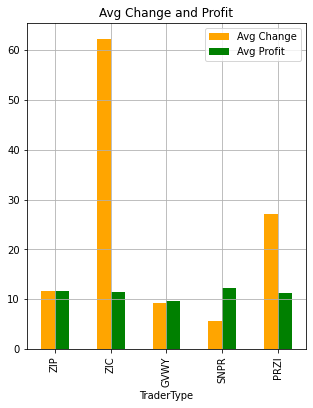

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('data.csv')
barplot = data[['Avg Change','Avg Profit','TraderType']].head()

barplot.plot.bar(x='TraderType',color =['orange','green'], title = "Avg Change and Profit", grid = True, figsize=(5,6), legend = True)
plt.show()

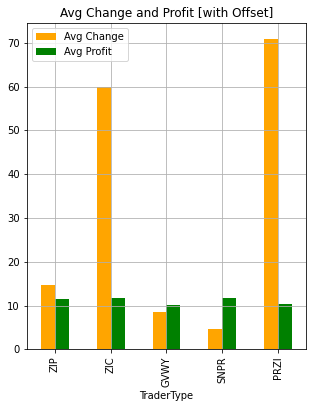

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('dataoffset.csv')
barplot = data[['Avg Change','Avg Profit','TraderType']].head()

barplot.plot.bar(x='TraderType',color =['orange','green'], title = "Avg Change and Profit [with Offset]", grid = True, figsize=(5,6), legend = True)
plt.show()

In [ ]:
#import pandas as pd

#df = pd.read_csv('_Assignment/avg_balance_GVWY.csv')
#testData= df.iloc[:, [2,3,5]] 
#testData.columns = ['bid' , 'best' , 'profit' ]

#count_bid= sum(list(map(lambda x: x.count("None"), testData['bid'])))
#count_best= sum(list(map(lambda x: x.count("None"), testData['best'])))

#testData['bid'] = pd.to_numeric(testData['bid'],errors ='coerce')
#testData['best'] = pd.to_numeric(testData['best'],errors ='coerce')



#testData['Change'] = testData.sub(testData.index[i+1]-testdata.index[i])
#testData['Change'] = testData['best']-testData['bid']
#testData['Change2'] = testData['profit'].diff()

#NoBid=count_bid
#NoOffer=count_best
#StandardDev = testData.std()
#MaxChange = testData['Change'].max()
#MaxProfit = testData['Change2'].max()
#AvgChange=StandardDev[3]
#AvgProfit=StandardDev[4]

#Transactions=len(testData.index)
#print(NoBid)
#print(str(testData.info()))